## ANTECEDENTES


Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.


## LIBRERÍAS

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFE

import warnings



In [3]:
warnings.filterwarnings("ignore")

## IMPORTACIÓN DE DATOS

In [4]:
contratos = pd.read_csv('final_provider/contract.csv')
personal = pd.read_csv('final_provider/personal.csv')
internet = pd.read_csv('final_provider/internet.csv')
telefono = pd.read_csv('final_provider/phone.csv')

## EDA

### Dataframe Contratos

In [5]:
contratos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
contratos.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


- No existen datos faltates 
- Existen columnas como las fechas o 'TotalCharges' cuyo tipo de dato es incorrecto
- Para una mayor facilidad se puede estandarizar el formato del título cambiando 'customerID' a 'CustomerID'
- Crear una nueva columna 'Churn' que va a ser el target

**Columna CostumnerID**

In [7]:
#Cambio de nombre columna 'customerID'
contratos.rename(columns={'customerID':'CustomerID'},inplace=True)


**Columna Churn**

In [8]:
#Creación de Churn en base a si tienen un 'EndDate'
contratos['Churn'] = np.where(contratos['EndDate'] == 'No',0,1)

In [9]:
contratos['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

Podemos ver que existen muchos mas casos de clientes que no han dejado la plataforma. Por lo cual existe un desbalance de clases

**Columna Begin Date**

In [10]:
#Cambio a formato tipo Datetime
contratos['BeginDate'] = pd.to_datetime(contratos['BeginDate'],format='%Y-%m-%d')

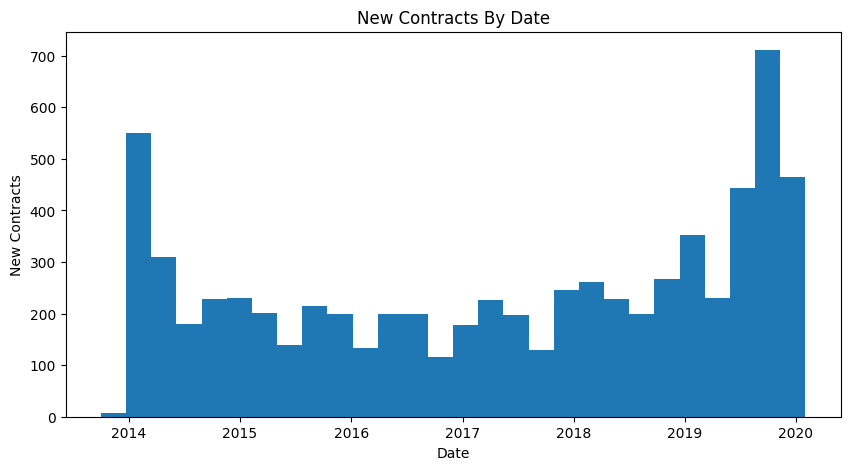

In [11]:
plt.figure(figsize=(10,5))
plt.hist(contratos['BeginDate'],bins=28)
plt.title('New Contracts By Date')
plt.xlabel('Date')
plt.ylabel('New Contracts')
plt.show()

- La creación de contratos tiene 2 picos muy marcados a inicios del 2014 y finales del 2019.
- Se puede ver una tendencia estable de nuevos clientes entre 2015 y 2018, año en que empieza a tener una tendencia al alza.


**Columna End Date**

In [12]:
#Cantidad de contratos finalizados por fecha
contratos['EndDate'].value_counts()

EndDate
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: count, dtype: int64

Gracias a la creación de Churn, podemos modificar 'EndDate'. Se va a colocar la fecha de toma de datos (2020-02-01) para reemplazar los valores 'No' y así transformar a tipo datetime. Posteriormente se va a calcular el tiempo que cada cliente ha tenido el servicio.

In [13]:
#Identación de la fecha donde se tomaron los datos en lugar de 'No'
contratos['EndDate'] = np.where(contratos['EndDate'] == 'No','2020-02-01 00:00:00',contratos['EndDate'])

#Transformación a tipo date
contratos['EndDate'] = pd.to_datetime(contratos['EndDate'])

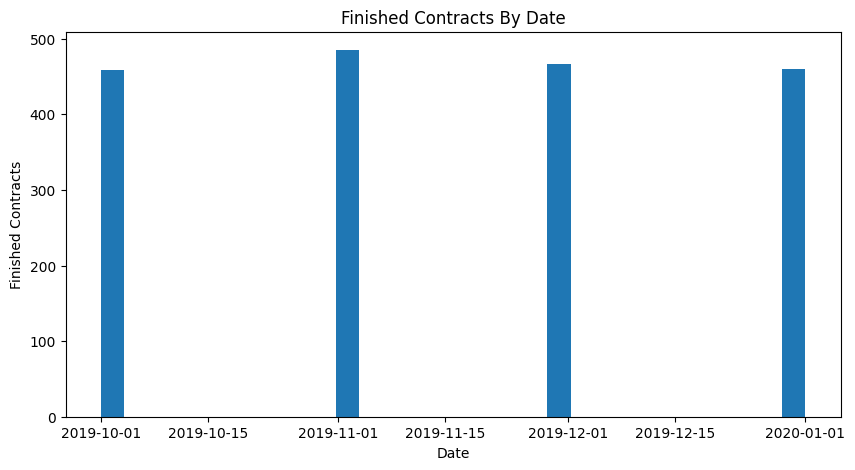

In [14]:
plt.figure(figsize=(10,5))
plt.hist(contratos[contratos['EndDate']<'2020-02-01']['EndDate'],bins=30)
plt.title('Finished Contracts By Date')
plt.xlabel('Date')
plt.ylabel('Finished Contracts')
plt.show()

Solo hay 4 fechas en las que existen registros de contratos finalizados.
Esto es un poco extraño debido a que se manejan muchos contratos mes a mes, y no haría sentido que todos terminen al mismo tiempo entre ellos, y junto a los que duran 1 o 2 años.

**Columna Duration**

In [15]:
#Cálculo de días transcurridos en cada contrato
contratos['Duration'] = (contratos['EndDate'] - contratos['BeginDate']).dt.days
contratos['Duration']

0         31
1       1036
2         61
3       1371
4         61
        ... 
7038     730
7039    2191
7040     337
7041     123
7042    2010
Name: Duration, Length: 7043, dtype: int64

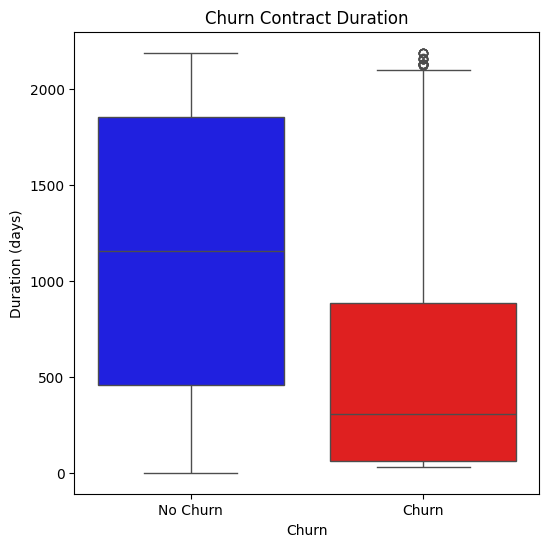

In [16]:
plt.figure(figsize=(6,6))
sns.boxplot(x=contratos['Churn'], y=contratos['Duration'],palette=['blue', 'red'])
plt.ylabel('Duration (days)')
plt.title('Churn Contract Duration')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()

Se puede observar, como era de esperarse, que la media de la duración en el contrato de los clientes que no han cancelado el servicio, es mucho mayor (cerca a 1100 días) comparada con aquellos que han terminado el contato (cerca a 250 días)

**Columna Type**

In [17]:
contratos['Type'].value_counts()

Type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [18]:
type = contratos.groupby('Type')['Churn'].sum()
type

Type
Month-to-month    1655
One year           166
Two year            48
Name: Churn, dtype: int64

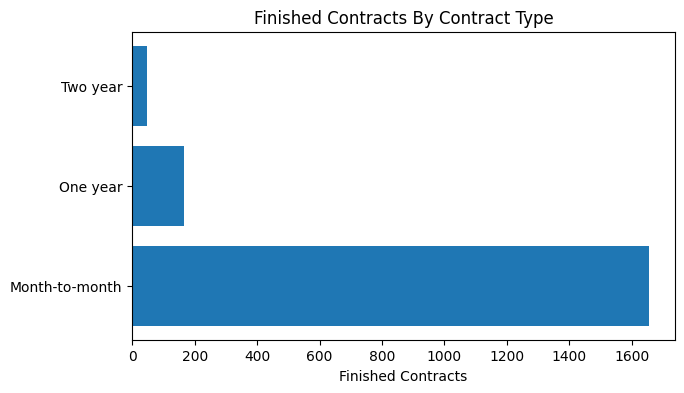

In [19]:
plt.figure(figsize=(7,4))
plt.barh(type.index,type.values)
plt.title('Finished Contracts By Contract Type')
plt.xlabel('Finished Contracts')
plt.show()

Es evidente que la gran mayoría de clientes que han cancelado su contrato, son aquellos que pagan mes a mes.

**Columna PaperlessBilling**

In [20]:
contratos['PaperlessBilling'].value_counts()

PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64

In [21]:
billing = contratos.groupby('PaperlessBilling')['Churn'].sum()
billing

PaperlessBilling
No      469
Yes    1400
Name: Churn, dtype: int64

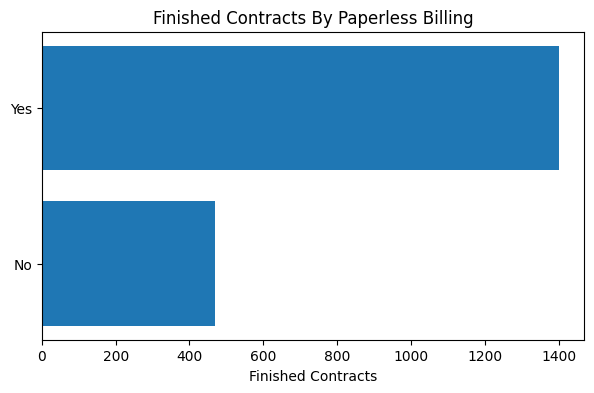

In [22]:
plt.figure(figsize=(7,4))
plt.barh(billing.index,billing.values)
plt.title('Finished Contracts By Paperless Billing')
plt.xlabel('Finished Contracts')
plt.show()

La mayoría de los que cancelan sus contratos, reciben su cuenta de manera física (en papel)

**Columna PaymentMethod**

In [23]:
contratos['PaymentMethod'].value_counts()

PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

In [24]:
payment = contratos.groupby('PaymentMethod')['Churn'].sum()
payment

PaymentMethod
Bank transfer (automatic)     258
Credit card (automatic)       232
Electronic check             1071
Mailed check                  308
Name: Churn, dtype: int64

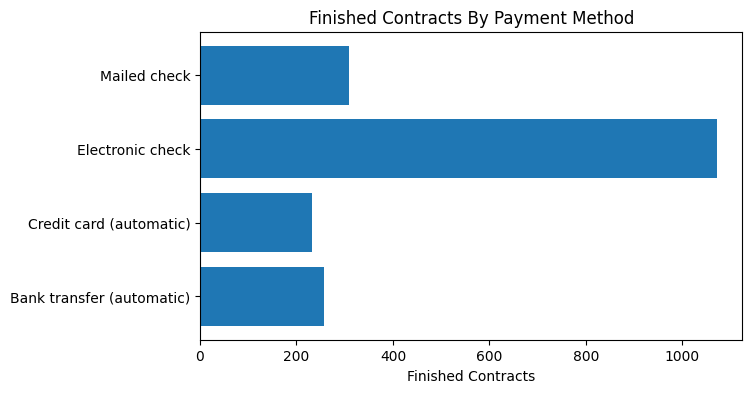

In [25]:
plt.figure(figsize=(7,4))
plt.barh(payment.index,payment.values)
plt.title('Finished Contracts By Payment Method')
plt.xlabel('Finished Contracts')
plt.show()

La mayoría de los que cancelan sus contratos, pagan mediante cheque electrónico 

**Columna Montly Charges**

In [26]:
contratos['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

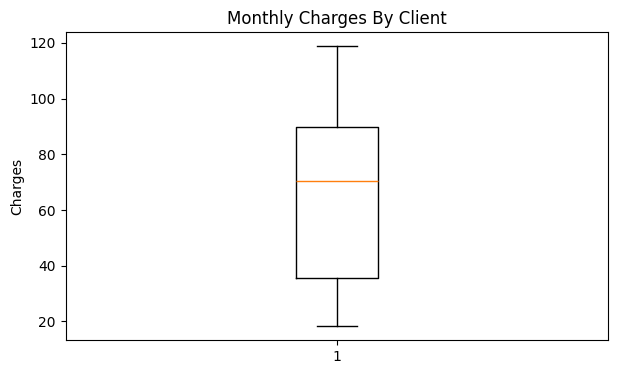

In [27]:
plt.figure(figsize=(7,4))
plt.boxplot(contratos['MonthlyCharges'])
plt.title('Monthly Charges By Client')
plt.ylabel('Charges')
plt.show()

Mensualmente, la empresa recibe una media de $65 por cliente

**Columna TotalCharges**

In [28]:
#Análisis de las filas con valores faltantes
clientes_nuevos = contratos[contratos['TotalCharges']==' ']
clientes_nuevos

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Duration
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0,0


- Todos los que no tienen valor en esta columna, son aquellos cuyos contratos empiezan en la fecha de corte de los datos. 
- Esto tiene sentido, y a la vez, se puede decir que al ser nuevos, no aportan información relevante que puede ser usada para entrenar el modelo de predicción.
- Basado en esto, se eliminan 11 registros.

In [29]:
#Eliminación filas sin valor en Total Charges
contratos.drop(clientes_nuevos.index,axis=0, inplace=True)

In [30]:
#Transformación a float
contratos['TotalCharges']= contratos['TotalCharges'].astype('float64')

In [31]:
contratos['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

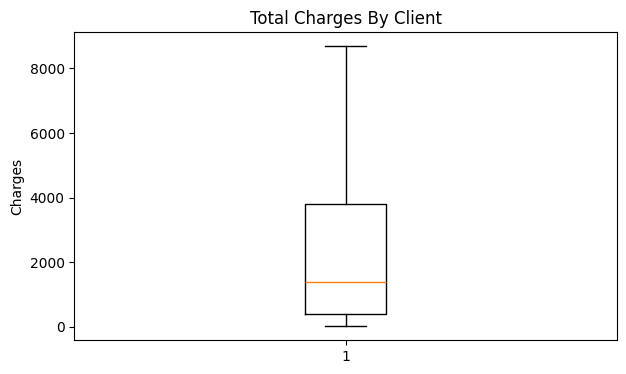

In [32]:
plt.figure(figsize=(7,4))
plt.boxplot(contratos['TotalCharges'])
plt.title('Total Charges By Client')
plt.ylabel('Charges')
plt.show()

In [33]:
#Dataframe luego de todos los cambios
contratos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Churn             7032 non-null   int64         
 9   Duration          7032 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 604.3+ KB


### DataFrame Datos Personales

In [34]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [35]:
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [36]:
#Eliminación clientes nuevos, sacados de la tabla contratos
personal.drop(clientes_nuevos.index,axis=0, inplace=True)

**Columna CustomerID**

In [37]:
#Cambio de nombre columna 'CustomerID'
personal.rename(columns={'customerID':'CustomerID'},inplace=True)

**Columna Gender**

In [38]:
#Cambio de nombre columna 'Gender'
personal.rename(columns={'gender':'Gender'},inplace=True)

In [39]:
personal['Gender'].value_counts()

Gender
Male      3549
Female    3483
Name: count, dtype: int64

La distribución entre clientes hombres y mujeres es totalmente igual

**Columna Senior Citizen**

In [40]:
personal['SeniorCitizen'].value_counts()

SeniorCitizen
0    5890
1    1142
Name: count, dtype: int64

La mayoría de los clientes no son Senior

**Columna Partner**

In [41]:
personal['Partner'].value_counts()

Partner
No     3639
Yes    3393
Name: count, dtype: int64

Distribución igualitaria entre las dos clases

**Columna Dependents**

In [42]:
personal['Dependents'].value_counts()

Dependents
No     4933
Yes    2099
Name: count, dtype: int64

Existe mas del doble de clientes con dependientes.

### DataFrame Servicio Internet

In [43]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [44]:
internet.sample(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1198,5240-IJOQT,Fiber optic,No,No,No,No,No,No
3646,0980-FEXWF,DSL,No,No,Yes,No,No,No
2800,7860-UXCRM,DSL,Yes,Yes,Yes,Yes,Yes,No
3795,1355-KUSBG,DSL,No,No,No,No,No,No
1381,1320-REHCS,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
4367,5550-VFRLC,Fiber optic,No,No,No,No,No,No
2271,7765-LWVVH,Fiber optic,Yes,Yes,No,No,Yes,No
65,2673-CXQEU,Fiber optic,Yes,Yes,Yes,No,Yes,Yes
1611,7519-JTWQH,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
4442,3841-CONLJ,DSL,No,No,No,No,No,Yes


**Columna CustomerID**

In [45]:
#Cambio de nombre columna 'CustomerID'
internet.rename(columns={'customerID':'CustomerID'},inplace=True)

**Columna Internet Service**

In [46]:
internet['InternetService'].value_counts()

InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

Existe una distribución equitativa entre los tipos de internet contratados

**Columna Online Security**

In [47]:
internet['OnlineSecurity'].value_counts()

OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int64

Hay mas clientes que no tienen contratada la Seguridad Online

**Columna Online Backup**

In [48]:
internet['OnlineBackup'].value_counts()

OnlineBackup
No     3088
Yes    2429
Name: count, dtype: int64

Hay mas clientes que no tienen contratado el Backup Online

**Columna Device Protection**

In [49]:
internet['DeviceProtection'].value_counts()

DeviceProtection
No     3095
Yes    2422
Name: count, dtype: int64

Hay mas clientes que no tienen contratado el servicio de Protección de Dispositivo

**Columna Tech Support**

In [50]:
internet['TechSupport'].value_counts()

TechSupport
No     3473
Yes    2044
Name: count, dtype: int64

Hay mas clientes que no tienen usado el servicio Técnico

**Columna Streaming TV**

In [51]:
internet['StreamingTV'].value_counts()

StreamingTV
No     2810
Yes    2707
Name: count, dtype: int64

La distribución es equitativa entre aquellos que han contratado el servicio de Streaming Tv y los que no lo han hecho

**Columna Streaming Movies**

In [52]:
internet['StreamingMovies'].value_counts()

StreamingMovies
No     2785
Yes    2732
Name: count, dtype: int64

La distribución es equitativa entre aquellos que han contratado el servicio de Streaming Movies y los que no lo han hecho

In [53]:
#Copia del Dataframe para comprobar correlación entre sus columnas
internet2 = internet.copy()
internet2.drop(columns='CustomerID', axis=0, inplace=True)
internet2 = internet2.replace({'DSL':1,'Fiber optic':0,'Yes':1,'No':0})
internet2

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,1,0,1,0,0,0,0
1,1,1,0,1,0,0,0
2,1,1,1,0,0,0,0
3,1,1,0,1,1,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
5512,1,1,0,1,1,1,1
5513,0,0,1,1,0,1,1
5514,1,1,0,0,0,0,0
5515,0,0,0,0,0,0,0


In [54]:
#Cálculo de correlación
correlacion = internet2.corr()

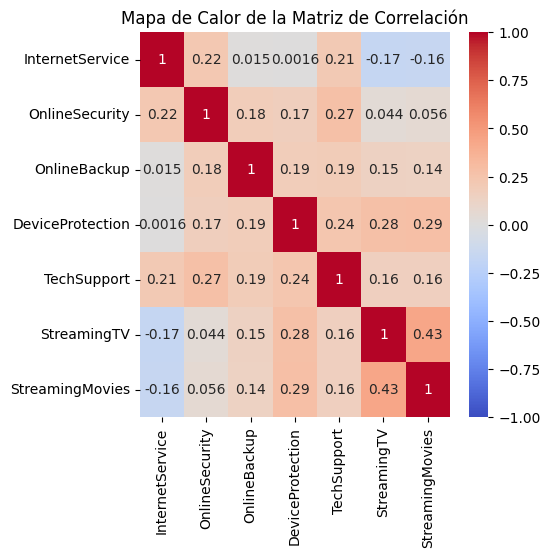

In [55]:
#Gráfico de correlación entre columnas
plt.figure(figsize=(5, 5))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

Según la gráfica, no existe una correlación alta (positiva o negativa) entre las columnas del dataframe, que me permitan eliminar cierta característica por comportarse igual a otra.
La correlación mas fuerte es de 0.4 entre Streaming TV y Streaming Movies

### DataFrame Servicio Telefónico

In [56]:
telefono.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [57]:
telefono.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


**Columna CustomerID**

In [58]:
#Cambio de nombre columna 'CustomerID'
telefono.rename(columns={'customerID':'CustomerID'},inplace=True)

**Columna Multiple Lines**

In [59]:
telefono['MultipleLines'].value_counts()

MultipleLines
No     3390
Yes    2971
Name: count, dtype: int64

Existen mas clientes que no tienen múltiples líneas

## PLAN DE TRABAJO

#### 1. Preparación de los Datos

Una vez analizados los datos y sus características podemos proceder a preparar las catacterísticas para entrenar los modelos:

1. Unión de tablas para añadir los datos de Internet, Teléfono y Cliente a la tabla contratos.
2. Eliminación columnas innecesarias (ID, EndDate) que no aportan información relevante.
3. Creación columnas Internet y Phone, ya que las columnas de esas tablas tiene información extra, como si hay líneas múltiples o si es Fibra óptica.
4. Codificación mediante One-Hot Encoding. La considero mas útil ya que la mayoría de columnas categóricas son binarias (Yes-No) y por ende no existe cardinalidad como para usar Ordinal Encoder.
5. Escalamiento de los datos con Min-Max scaler (junto a OHE todo queda entre 0 y 1).
4. Separación en conjuntos de entrenamiento y prueba. 
3. Correción del desequilibrio de clases mediante sobre muestreo. Creo que la cantidad de datos no es suficientemente alta como para intentar sub-muestreo (7032 filas), mas aún considerando que el desbalance es aproximadamente de 3 a 1 entre la clase negativa y positiva.


#### 2. Establecer modelos para hacer pruebas

Tomando en cuenta que tenemos un problema de clasificación, vamos a probar los siguientes modelos:

1. Regresión Logística: la mas sencilla de aplicar, nos puede dar una base en las métricas que queremos conseguir. Si tiene un rendimiento bajo en AUC-ROC, sugiere que la relación no es completamente lineal.
2. Árbol de Clasificación: Puede capturar mejor relaciones no líneales, aunque por su sencillez, puede sobre ajustarse y no obtener una gran mejora en AUC-ROC.
3. Bosque aletario: Modelo mas complejo conformado por conjuntos de árboles (mas hiperparámetros por alterar), puede capturar relaciones mas complejas y a la vez, brindar estabilidad al modelo.
4. XGBoost: el modelo mas complejo basado en boosting, cuya minimización de la función de error nos ayuda a obtener métricas mejoradas respecto a los anteriores. Permite un ajuste mas fino a cambio de una mayor complejidad computacional.

Luego procedemos a: 

- Correr cada modelo con los datos preparados para cada uno en la etapa anterior.
- Evaluar mediante la métrica AUC-ROC (0.88 en el conjunto de prueba)y Exactitud cada modelo para su conjunto de entrenamiento y prueba.
- Dependiendo de los resultados inciiales, se va a establecer en cada modelo un sub proceso de modificación de hiperparámetros, para mejorar las métricas. 
- En caso de no obtener los resultados requeridos luego de pasar por los 4 elegidos:
    - Se puede optar por modificar alguna parte de la preparación de datos, como por ejemplo: otro escalamiento o codificación. 
    - Remoción de características que no aporten al entrenamiento o de aquellas generadas a partir de otros datos, como 'Duration'.
    - Prueba de un modelo no considerado incialmente.

#### 3. Modelo Escogido
1. Escoger un modelo en base a los criterios: 
    - Obtiene AUC-ROC requerido (0.88).
    - El mas simple entre los que cumplan el criterio anterior (menor costo computacional).
2. Volver a Correr el modelo que consiguió el valor de AUC-ROC requerido (0.88) con los mejores hiperparámetros y adicionar una validación cruzada para comprobar su robustez general.
3. Comprobar que variables fueron mas relevantes en su entrenamiento.

#### 4. Elaborar Conclusiones
- Establecer como el EDA determinó la elaboración del plan de trabajo
- Indicar si se cumplieron las etapas de la preparación de datos 
- Cómo se hicieron las pruebas y comparaciones entre modelos 
- Qué modelo se escogió y bajo qué argumentos
- Conclusiones respecto a las características y predicciones del modelo escogido


## PREPARACIÓN DE DATOS

### 1. Unión de Tablas

Se van a juntar el resto de características incluídas en las tablas adicionales, para consolidar las características y verificar los datos en conjunto.

In [60]:
#Unión de tablas contratos, personal, internet y teléfono
resumen = pd.merge(left=contratos,right=personal,on='CustomerID',how='left').merge(right=internet,on='CustomerID',how='left').merge(right=telefono,on='CustomerID',how='left')

In [61]:
resumen.sample(10)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Duration,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
4583,8003-EWNDZ,2019-04-01,2020-02-01,Month-to-month,Yes,Electronic check,21.20,222.65,0,306,...,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3599,8148-BPLZQ,2017-04-01,2020-02-01,Month-to-month,Yes,Electronic check,49.80,1734.20,0,1036,...,No,No,DSL,No,Yes,No,No,No,No,No
3928,8285-ABVLB,2014-04-01,2020-02-01,Two year,No,Credit card (automatic),19.85,1328.35,0,2132,...,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2452,5198-EFNBM,2015-05-01,2020-02-01,One year,Yes,Electronic check,90.65,5199.80,0,1737,...,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,No
2876,4003-OCTMP,2017-07-01,2020-02-01,One year,Yes,Electronic check,64.00,1910.75,0,945,...,Yes,No,DSL,Yes,No,No,Yes,No,Yes,No
3102,5038-ETMLM,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),113.65,8182.75,0,2191,...,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
5503,3173-NVMPX,2019-05-01,2020-02-01,Month-to-month,Yes,Mailed check,55.30,501.20,0,276,...,Yes,Yes,DSL,No,Yes,No,No,No,No,Yes
6078,8319-QBEHW,2017-12-01,2020-02-01,One year,Yes,Bank transfer (automatic),39.95,1023.75,0,792,...,No,Yes,DSL,No,Yes,No,No,Yes,No,NaN
5107,6374-AFWOX,2016-04-01,2020-02-01,Two year,No,Mailed check,65.65,3047.15,0,1401,...,Yes,No,DSL,Yes,Yes,Yes,Yes,No,No,No
1859,7105-MXJLL,2017-12-01,2020-02-01,One year,No,Mailed check,60.70,1597.40,0,792,...,Yes,No,DSL,No,No,Yes,No,No,Yes,No


Comprobación de que todos los clientes tienen algún servicio contratado

In [62]:
#Comprobación de clientes con nulos en teléfono e internet
resumen[(resumen['MultipleLines'].isna()) &(resumen['InternetService'].isna())]

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Duration,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines


### 2. Eliminación de Columnas

- Se elimina CustomerID porque su función es únicamente identificar cada cliente y permitir unir las tablas
- Begin Date, porque se usó para crear una nueva columna 'Duration'
- End Date, porque se usó para 'Duration'. Además, después de analizar su variabilidad, se intuye que no están las fechas exactas en que se dió de baja cada cliente, sino que se acumularon y registraron a grandes grupos de clientes en una misma fecha, lo cuál llevó a tener solo 4 valores diferentes.

In [63]:
resumen = resumen.drop(columns=['CustomerID', 'BeginDate','EndDate'],axis=1)

In [64]:
resumen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Churn             7032 non-null   int64  
 6   Duration          7032 non-null   int64  
 7   Gender            7032 non-null   object 
 8   SeniorCitizen     7032 non-null   int64  
 9   Partner           7032 non-null   object 
 10  Dependents        7032 non-null   object 
 11  InternetService   5512 non-null   object 
 12  OnlineSecurity    5512 non-null   object 
 13  OnlineBackup      5512 non-null   object 
 14  DeviceProtection  5512 non-null   object 
 15  TechSupport       5512 non-null   object 
 16  StreamingTV       5512 non-null   object 


### 3. Creación de Columnas

- Debido a que la tabla Internet tiene datos de cada tipo de servicio, se va a crear una columna 'Internet' que nos indique si tiene o no este servicio, para eliminar los nulos en aquellos que solo tienen teléfono.
- Se va a realizar lo mismo con la tabla telefono y una nueva columna 'Phone'
- De acuerdo a los resultados obtenidos en los modelos posteriormente, se plantea mas adelante crear una columna que resuman todos los servicios de acuerdo a la cantidad total que posee cada cliente.

In [65]:
#Colocamos 0 para los clientes que no tienen Internet o Teléfono (NaN), y 1 para los que si
resumen['Internet'] = np.where(resumen['InternetService'].isna(),0,1)
resumen['Phone'] = np.where(resumen['MultipleLines'].isna(),0,1)

In [66]:
resumen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Churn             7032 non-null   int64  
 6   Duration          7032 non-null   int64  
 7   Gender            7032 non-null   object 
 8   SeniorCitizen     7032 non-null   int64  
 9   Partner           7032 non-null   object 
 10  Dependents        7032 non-null   object 
 11  InternetService   5512 non-null   object 
 12  OnlineSecurity    5512 non-null   object 
 13  OnlineBackup      5512 non-null   object 
 14  DeviceProtection  5512 non-null   object 
 15  TechSupport       5512 non-null   object 
 16  StreamingTV       5512 non-null   object 


In [67]:
resumen.sample(10)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Duration,Gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Internet,Phone
6337,Month-to-month,Yes,Credit card (automatic),49.25,49.25,1,31,Male,1,Yes,...,DSL,No,No,No,Yes,No,No,No,1,1
3067,One year,Yes,Electronic check,79.40,4820.55,0,1857,Female,0,Yes,...,DSL,Yes,Yes,Yes,Yes,No,Yes,Yes,1,1
4090,Month-to-month,Yes,Credit card (automatic),99.15,6171.20,0,1949,Male,0,No,...,Fiber optic,No,Yes,No,Yes,Yes,Yes,No,1,1
4177,Month-to-month,Yes,Bank transfer (automatic),79.90,343.95,1,153,Male,1,Yes,...,Fiber optic,No,No,Yes,No,No,No,Yes,1,1
3302,Two year,No,Electronic check,79.65,3870.30,0,1461,Female,0,Yes,...,DSL,No,Yes,No,Yes,Yes,Yes,Yes,1,1
2585,Month-to-month,No,Bank transfer (automatic),88.40,2191.15,0,761,Female,1,Yes,...,Fiber optic,No,Yes,Yes,No,No,Yes,No,1,1
3022,Month-to-month,Yes,Mailed check,20.70,137.60,0,245,Female,0,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,1
5318,Two year,No,Mailed check,19.70,599.25,0,914,Female,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,1
4880,One year,Yes,Electronic check,106.05,4510.80,0,1340,Male,0,No,...,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,No,1,1
5107,Two year,No,Mailed check,65.65,3047.15,0,1401,Male,0,Yes,...,DSL,Yes,Yes,Yes,Yes,No,No,No,1,1


Imputación de Valores:
- Se va a colocar 'No' en todos los valores faltantes de los clientes que no tienen los servicios de la tabla Internet para las columnas: 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'.
- Se va a colocar 'No' en todos los valores faltantes de los clientes que no tienen los servicios de la tabla telefono, para la columna 'MultipleLines' 

In [68]:
resumen = resumen.fillna('No')

In [69]:
resumen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Churn             7032 non-null   int64  
 6   Duration          7032 non-null   int64  
 7   Gender            7032 non-null   object 
 8   SeniorCitizen     7032 non-null   int64  
 9   Partner           7032 non-null   object 
 10  Dependents        7032 non-null   object 
 11  InternetService   7032 non-null   object 
 12  OnlineSecurity    7032 non-null   object 
 13  OnlineBackup      7032 non-null   object 
 14  DeviceProtection  7032 non-null   object 
 15  TechSupport       7032 non-null   object 
 16  StreamingTV       7032 non-null   object 


In [70]:
resumen.sample(10)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Duration,Gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Internet,Phone
89,Month-to-month,No,Mailed check,33.75,1009.25,0,883,Male,0,Yes,...,DSL,No,No,No,No,Yes,No,No,1,0
4380,Two year,No,Mailed check,19.40,358.05,0,518,Female,0,No,...,No,No,No,No,No,No,No,No,0,1
3353,Month-to-month,Yes,Mailed check,19.95,416.40,0,641,Male,0,No,...,No,No,No,No,No,No,No,No,0,1
1623,Month-to-month,Yes,Electronic check,90.05,2627.20,0,914,Female,1,Yes,...,Fiber optic,No,Yes,No,No,Yes,No,Yes,1,1
1838,Two year,No,Credit card (automatic),19.70,1415.85,0,2163,Female,0,Yes,...,No,No,No,No,No,No,No,No,0,1
705,Two year,Yes,Mailed check,59.60,3739.80,0,1979,Female,0,No,...,DSL,Yes,Yes,No,Yes,No,No,No,1,1
2159,Two year,Yes,Credit card (automatic),101.10,6994.80,0,2132,Male,0,Yes,...,Fiber optic,Yes,Yes,Yes,Yes,Yes,No,No,1,1
1251,Month-to-month,Yes,Electronic check,30.90,59.05,1,61,Female,0,No,...,DSL,No,No,No,Yes,No,No,No,1,0
653,Month-to-month,No,Electronic check,19.65,164.30,1,245,Female,1,No,...,No,No,No,No,No,No,No,No,0,1
301,Month-to-month,Yes,Electronic check,95.45,396.10,1,122,Female,1,No,...,Fiber optic,No,No,No,No,Yes,Yes,Yes,1,1


### Separación Características - Objetivo

In [71]:
features = resumen.drop(columns='Churn',axis=1)
target = resumen['Churn']

### 4. Codificación 

Se va a utilizar One Hot Encoding para dejar todas las columnas en un rango de 0 a 1

In [72]:
features_ohe = pd.get_dummies(features,drop_first=True)
features_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7032 non-null   float64
 1   TotalCharges                           7032 non-null   float64
 2   Duration                               7032 non-null   int64  
 3   SeniorCitizen                          7032 non-null   int64  
 4   Internet                               7032 non-null   int64  
 5   Phone                                  7032 non-null   int64  
 6   Type_One year                          7032 non-null   bool   
 7   Type_Two year                          7032 non-null   bool   
 8   PaperlessBilling_Yes                   7032 non-null   bool   
 9   PaymentMethod_Credit card (automatic)  7032 non-null   bool   
 10  PaymentMethod_Electronic check         7032 non-null   bool   
 11  Paym

In [73]:
features_ohe.sample(10)

,MonthlyCharges,TotalCharges,Duration,SeniorCitizen,Internet,Phone,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
3366,104.90,5913.95,1737,1,1,1,False,False,True,False,...,False,True,False,False,True,False,True,True,True,True
4425,75.65,302.35,123,0,1,1,False,False,True,False,...,False,True,False,False,False,False,False,False,False,True
1457,20.00,666.75,1095,0,0,1,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1820,54.20,1739.60,975,0,1,1,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
1044,50.25,152.30,92,0,1,1,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
5465,84.60,84.60,31,0,1,1,False,False,True,False,...,False,True,False,False,False,False,False,True,False,True
1734,69.90,69.90,30,0,1,1,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False
4228,95.65,5471.75,1706,1,1,1,True,False,False,False,...,False,True,False,True,True,True,True,False,False,True
3555,80.50,2088.80,791,0,1,1,False,False,True,False,...,False,True,False,False,False,False,True,False,False,True
868,98.20,7015.90,2191,0,1,1,False,True,True,False,...,False,True,False,True,False,True,True,True,False,True


### 5. Escalamiento de Datos

In [74]:
#Estabelcer las variables numéricas
numericas = ['MonthlyCharges','TotalCharges','Duration']

In [75]:
#Aplicación de escalamiento mediante MinMaxScaler
escalador = MinMaxScaler()
features_ohe[numericas]= escalador.fit_transform(features_ohe[numericas])
features_ohe.sample(10)

,MonthlyCharges,TotalCharges,Duration,SeniorCitizen,Internet,Phone,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
2421,0.173134,0.072381,0.225821,0,1,0,False,False,True,True,...,False,False,False,False,True,True,False,False,False,False
2224,0.519900,0.031779,0.043036,0,1,1,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4576,0.555721,0.578375,0.958815,1,1,1,False,True,False,True,...,False,False,False,True,False,True,True,False,True,True
2213,0.634328,0.690174,0.987043,0,1,1,False,True,True,True,...,True,False,False,True,False,True,True,True,True,False
1984,0.279602,0.189620,0.479870,0,1,0,False,True,True,True,...,True,False,False,True,False,False,True,True,False,False
5870,0.425871,0.230741,0.451643,0,1,1,False,True,True,False,...,False,False,False,True,True,False,True,False,False,False
2026,0.067662,0.012312,0.056918,0,1,0,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1523,0.377612,0.124002,0.254512,0,1,1,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
5891,0.218408,0.165013,0.506710,0,1,0,False,False,False,False,...,True,False,False,True,True,True,False,False,False,False
6387,0.733333,0.378750,0.492827,1,1,1,False,False,True,True,...,False,True,False,False,True,False,False,True,False,True


### 6. Separación en Train y Target

Se va a separar en 3 grupos:
- Entrenamiento: con el 60% de los datos
- Validación: con el 20% de los datos
- Prueba: con el 20% de los datos

In [76]:
features_train,features_test,target_train,target_test = train_test_split (features_ohe,target, 
                                                                          test_size=0.4,random_state=12345)

In [77]:
features_valid,features_test,target_valid,target_test = train_test_split (features_test,target_test, 
                                                                          test_size=0.5,random_state=12345)

In [78]:
print('Tamaños Grupos')
print('-----------------------------------------')
print('Características Entrenamiento',features_train.shape)
print('Características Validación',features_valid.shape)
print('Características Prueba',features_test.shape)
print('Objetivo Entrenamiento',target_train.shape)
print('Objetivo Entrenamiento',target_valid.shape)
print('Objetivo Prueba',target_test.shape)

Tamaños Grupos
-----------------------------------------
Características Entrenamiento (4219, 24)
Características Validación (1406, 24)
Características Prueba (1407, 24)
Objetivo Entrenamiento (4219,)
Objetivo Entrenamiento (1406,)
Objetivo Prueba (1407,)


### 7. Balanceo De Clases

El balanceo de clases se va a aplicar sobre el grupo de entrenamiento 'features_train' y 'target_train'.

Se va a optar por usar SMOTE en lugar de un oversampling manual

In [81]:
print("Distribución antes de SMOTE:", Counter(target_train))

Distribución antes de SMOTE: Counter({0: 3097, 1: 1122})


In [82]:
smote = SMOTE(sampling_strategy='auto', random_state=12345)
features_up, target_up = smote.fit_resample(features_train, target_train)

In [83]:
print("Distribución despues de SMOTE:", Counter(target_up))

Distribución despues de SMOTE: Counter({0: 3097, 1: 3097})


In [84]:
features_up.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         6194 non-null   float64
 1   TotalCharges                           6194 non-null   float64
 2   Duration                               6194 non-null   float64
 3   SeniorCitizen                          6194 non-null   int64  
 4   Internet                               6194 non-null   int64  
 5   Phone                                  6194 non-null   int64  
 6   Type_One year                          6194 non-null   bool   
 7   Type_Two year                          6194 non-null   bool   
 8   PaperlessBilling_Yes                   6194 non-null   bool   
 9   PaymentMethod_Credit card (automatic)  6194 non-null   bool   
 10  PaymentMethod_Electronic check         6194 non-null   bool   
 11  Paym

In [85]:
target_up.info()

<class 'pandas.core.series.Series'>
RangeIndex: 6194 entries, 0 to 6193
Series name: Churn
Non-Null Count  Dtype
--------------  -----
6194 non-null   int64
dtypes: int64(1)
memory usage: 48.5 KB


## MODELOS DE PREDICCIÓN

#### 1. Regresión Logística

In [86]:
#Creación/Entrenamiento de Regresión Logística
regresion = LogisticRegression(solver='liblinear')
regresion.fit(features_up,target_up)
regresion_prob = regresion.predict_proba(features_valid)[:,1]
regresion_pred = regresion.predict(features_valid)

#Cálculo de métricas
regresion_auc = roc_auc_score(target_valid,regresion_prob)
regresion_acc = accuracy_score(target_valid,regresion_pred)
regresion_f1 = f1_score(target_valid,regresion_pred)
regresion_rec = recall_score(target_valid,regresion_pred)
print(f'AUC-ROC: {regresion_auc:.2f} | Exactitud: {regresion_acc:.2f} | F1: {regresion_f1:.2f} | Recall: {regresion_rec:.2f}')


AUC-ROC: 0.84 | Exactitud: 0.76 | F1: 0.62 | Recall: 0.77


**Cambio Umbral**

Intento de Cambio de umbral para comprobar si mejoran las métricas de interes:

In [87]:
#Bases de comparación
best_acc = 0
best_auc = 0
best_threshold= 0

# Lazo para probar la respuesta de los scores ante el cambio de umbral
for threshold in np.arange(0.2, 0.6, 0.02):
    regresion_pred = regresion_prob > threshold
    
    thresh_acc = accuracy_score(target_valid,regresion_pred)
    thresh_recall = recall_score(target_valid,regresion_pred)
    thresh_f1 = f1_score(target_valid,regresion_pred)
    print(f'Recall={thresh_recall:.2f} | F1: {thresh_f1:.2f} | Exactitud = {thresh_acc:.2f} | Threshold: {threshold:.2f}')

Recall=0.95 | F1: 0.55 | Exactitud = 0.60 | Threshold: 0.20
Recall=0.94 | F1: 0.56 | Exactitud = 0.61 | Threshold: 0.22
Recall=0.93 | F1: 0.56 | Exactitud = 0.62 | Threshold: 0.24
Recall=0.93 | F1: 0.57 | Exactitud = 0.63 | Threshold: 0.26
Recall=0.92 | F1: 0.58 | Exactitud = 0.65 | Threshold: 0.28
Recall=0.92 | F1: 0.59 | Exactitud = 0.66 | Threshold: 0.30
Recall=0.91 | F1: 0.59 | Exactitud = 0.67 | Threshold: 0.32
Recall=0.90 | F1: 0.60 | Exactitud = 0.68 | Threshold: 0.34
Recall=0.90 | F1: 0.61 | Exactitud = 0.70 | Threshold: 0.36
Recall=0.90 | F1: 0.62 | Exactitud = 0.72 | Threshold: 0.38
Recall=0.86 | F1: 0.62 | Exactitud = 0.72 | Threshold: 0.40
Recall=0.84 | F1: 0.62 | Exactitud = 0.73 | Threshold: 0.42
Recall=0.82 | F1: 0.62 | Exactitud = 0.73 | Threshold: 0.44
Recall=0.80 | F1: 0.61 | Exactitud = 0.74 | Threshold: 0.46
Recall=0.79 | F1: 0.62 | Exactitud = 0.75 | Threshold: 0.48
Recall=0.77 | F1: 0.62 | Exactitud = 0.76 | Threshold: 0.50
Recall=0.73 | F1: 0.62 | Exactitud = 0.7

Se puede apreciar que la Exactitud mejora a medida que se eleva el umbral, esto tiene sentido ya que genera mas predicciones de no abandono, y coincide en mayor medida con el target_test que tiene mas casos 0. 
Sin embargo, este mismo efecto se puede apreciar a la inversa, donde el recall comienza a decaer. 

**Gráfico Curva ROC** 

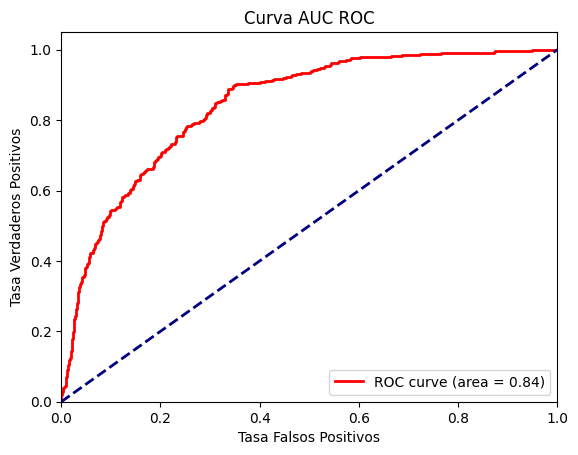

In [88]:
#Parámetros para curva roc
fpr, tpr, thresholds = roc_curve(target_valid, regresion_prob)

#Gráfico curva ACU-ROC
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {regresion_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Curva AUC ROC')
plt.legend(loc="lower right")
plt.show()

#### 2. Arbol de Clasificación

In [89]:
#Bases de comparación 
best_depth = 0
best_tree_auc = 0.5
best_tree_acc = 0
best_tree_f1 = 0
best_tree_rec = 0

#Pruebas de exactitud de acuerdo a la profundidad 
for i in range(2,12):
    arbol = DecisionTreeClassifier(max_depth=i,random_state=12345)
    arbol.fit(features_up,target_up)
    arbol_prob = arbol.predict_proba(features_valid)[:,1]
    arbol_pred = arbol.predict(features_valid)
    arbol_auc = roc_auc_score(target_valid,arbol_prob)
    arbol_acc = accuracy_score(target_valid,arbol_pred)
    arbol_f1 = f1_score(target_valid,arbol_pred)
    arbol_rec = recall_score(target_valid,arbol_pred)
    
    if arbol_auc > best_tree_auc:
        best_tree_auc = arbol_auc
        best_depth = i
        best_tree_acc = arbol_acc
        best_tree_f1 = arbol_f1
        best_tree_rec = arbol_rec
    
print(f'AUC-ROC: {best_tree_auc:.2f} | Best Depth: {best_depth} | Exactitud: {best_tree_acc} | F1: {best_tree_f1} | Recall: {best_tree_rec}' )


AUC-ROC: 0.85 | Best Depth: 6 | Exactitud: 0.7532005689900427 | F1: 0.6374085684430512 | Recall: 0.8288043478260869


In [90]:
#Generación de modelo con max_depth= beste depth
arbol = DecisionTreeClassifier(max_depth=best_depth,random_state=12345)
arbol.fit(features_up,target_up)

DecisionTreeClassifier(max_depth=6, random_state=12345)

In [91]:
for threshold in np.arange(0.2, 0.6, 0.02):
    arbol_pred = arbol_prob > threshold
    
    thresh_acc = accuracy_score(target_valid,arbol_pred)
    thresh_recall = recall_score(target_valid,arbol_pred)
    thresh_f1 = f1_score(target_valid,arbol_pred)
    print(f'Recall={thresh_recall:.2f} | F1: {thresh_f1:.2f} | Exactitud = {thresh_acc:.2f} | Threshold: {threshold:.2f}')

Recall=0.83 | F1: 0.58 | Exactitud = 0.69 | Threshold: 0.20
Recall=0.82 | F1: 0.58 | Exactitud = 0.69 | Threshold: 0.22
Recall=0.82 | F1: 0.58 | Exactitud = 0.69 | Threshold: 0.24
Recall=0.81 | F1: 0.59 | Exactitud = 0.70 | Threshold: 0.26
Recall=0.81 | F1: 0.59 | Exactitud = 0.70 | Threshold: 0.28
Recall=0.80 | F1: 0.59 | Exactitud = 0.71 | Threshold: 0.30
Recall=0.79 | F1: 0.59 | Exactitud = 0.71 | Threshold: 0.32
Recall=0.79 | F1: 0.59 | Exactitud = 0.71 | Threshold: 0.34
Recall=0.77 | F1: 0.60 | Exactitud = 0.73 | Threshold: 0.36
Recall=0.75 | F1: 0.59 | Exactitud = 0.73 | Threshold: 0.38
Recall=0.74 | F1: 0.60 | Exactitud = 0.74 | Threshold: 0.40
Recall=0.73 | F1: 0.60 | Exactitud = 0.75 | Threshold: 0.42
Recall=0.73 | F1: 0.60 | Exactitud = 0.75 | Threshold: 0.44
Recall=0.73 | F1: 0.60 | Exactitud = 0.75 | Threshold: 0.46
Recall=0.73 | F1: 0.60 | Exactitud = 0.75 | Threshold: 0.48
Recall=0.73 | F1: 0.60 | Exactitud = 0.75 | Threshold: 0.50
Recall=0.72 | F1: 0.60 | Exactitud = 0.7

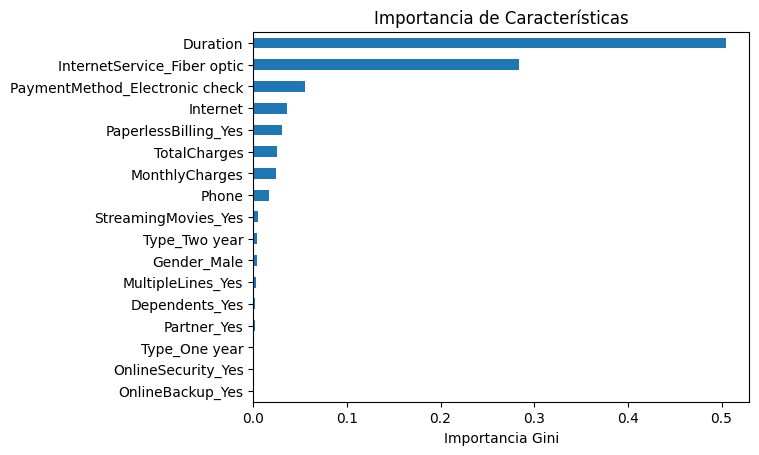

In [92]:
#Gráfico de los variables que el modelo considera mas relevantes
ver_imp= pd.DataFrame({'valor':arbol.feature_importances_},index=features_train.columns)
ver_imp.sort_values(by='valor', ascending=True,inplace=True)
ver_imp.query("valor > 0",inplace=True)
ver_imp.plot(kind='barh')
plt.title('Importancia de Características')
plt.xlabel('Importancia Gini')
plt.legend().remove()
plt.show()

**Gráfico Curva ROC**

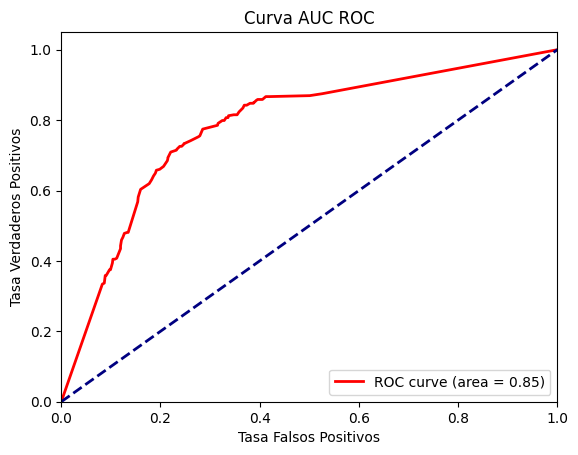

In [93]:
#Parámetros para curva roc
fpr, tpr, thresholds = roc_curve(target_valid, arbol_prob)

#Gráfico curva ACU-ROC
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {best_tree_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Curva AUC ROC')
plt.legend(loc="lower right")
plt.show()

#### 3. Random Forest

In [94]:
#Bases de comparación 
best_depth = 0
best_forest_auc = 0.5
best_e=10
best_forest_acc = 0
best_forest_f1 = 0
best_forest_rec = 0

#Pruebas de exactitud de acuerdo a la profundidad y estimadores
for i in range(2,11):
    for e in range (20,110,10):
        #Creación árbol con profundidad variable
        bosque = RandomForestClassifier(random_state=12345, n_estimators=e, max_depth=i)
        bosque.fit(features_up,target_up)
        bosque_prob = bosque.predict_proba(features_valid)[:,1]
        bosque_auc = roc_auc_score(target_valid,bosque_prob)
        bosque_pred = bosque.predict(features_valid)
        bosque_acc = accuracy_score(target_valid,bosque_pred)
        bosque_f1 = f1_score(target_valid,bosque_pred)
        bosque_rec = recall_score(target_valid,bosque_pred)    
        
        #Asignación de mejor exactitud en base a profundidad
        if bosque_auc > best_forest_auc:
            best_forest_auc = bosque_auc
            best_depth = i
            best_e=e
            best_forest_acc = bosque_acc
            best_forest_f1 = bosque_f1
            best_forest_rec = bosque_rec

print (f'AUC ROC: {best_forest_auc:.3f} | Estimadores: {best_e} | Profundidad:{best_depth} | Exactitud: {best_forest_acc:.2f} | F1: {best_forest_f1:.2f} | Recall: {best_forest_rec:.2f}')

AUC ROC: 0.867 | Estimadores: 40 | Profundidad:9 | Exactitud: 0.78 | F1: 0.65 | Recall: 0.78


In [95]:
#Generación de modelo con Estimadores: 40 y Profundidad:9
bosque = RandomForestClassifier(random_state=12345, n_estimators=best_e, max_depth=best_depth)
bosque.fit(features_up,target_up)

RandomForestClassifier(max_depth=9, n_estimators=40, random_state=12345)

In [96]:
for threshold in np.arange(0.2, 0.6, 0.02):
    bosque_pred = bosque_prob > threshold
    
    thresh_acc = accuracy_score(target_valid,bosque_pred)
    thresh_recall = recall_score(target_valid,bosque_pred)
    thresh_f1 = f1_score(target_valid,bosque_pred)
    print(f'Recall={thresh_recall:.2f} | F1: {thresh_f1:.2f} | Exactitud = {thresh_acc:.2f} | Threshold: {threshold:.2f}')

Recall=0.96 | F1: 0.56 | Exactitud = 0.61 | Threshold: 0.20
Recall=0.95 | F1: 0.57 | Exactitud = 0.62 | Threshold: 0.22
Recall=0.95 | F1: 0.58 | Exactitud = 0.64 | Threshold: 0.24
Recall=0.94 | F1: 0.58 | Exactitud = 0.65 | Threshold: 0.26
Recall=0.93 | F1: 0.59 | Exactitud = 0.67 | Threshold: 0.28
Recall=0.90 | F1: 0.59 | Exactitud = 0.68 | Threshold: 0.30
Recall=0.89 | F1: 0.60 | Exactitud = 0.69 | Threshold: 0.32
Recall=0.88 | F1: 0.60 | Exactitud = 0.70 | Threshold: 0.34
Recall=0.86 | F1: 0.61 | Exactitud = 0.71 | Threshold: 0.36
Recall=0.85 | F1: 0.62 | Exactitud = 0.73 | Threshold: 0.38
Recall=0.83 | F1: 0.62 | Exactitud = 0.73 | Threshold: 0.40
Recall=0.83 | F1: 0.63 | Exactitud = 0.74 | Threshold: 0.42
Recall=0.82 | F1: 0.63 | Exactitud = 0.75 | Threshold: 0.44
Recall=0.80 | F1: 0.64 | Exactitud = 0.76 | Threshold: 0.46
Recall=0.78 | F1: 0.64 | Exactitud = 0.77 | Threshold: 0.48
Recall=0.76 | F1: 0.64 | Exactitud = 0.77 | Threshold: 0.50
Recall=0.75 | F1: 0.64 | Exactitud = 0.7

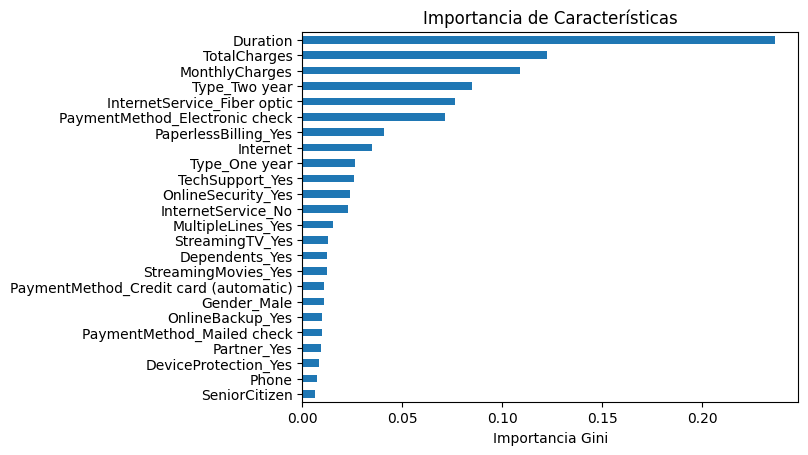

In [97]:
#Gráfico de los variables que el modelo considera mas relevantes
ver_imp= pd.DataFrame({'valor':bosque.feature_importances_},index=features_train.columns)
ver_imp.sort_values(by='valor', ascending=True,inplace=True)
ver_imp.query("valor > 0",inplace=True)
ver_imp.plot(kind='barh')
plt.title('Importancia de Características')
plt.xlabel('Importancia Gini')
plt.legend().remove()
plt.show()
plt.show()

**Gráfico Curva ROC**

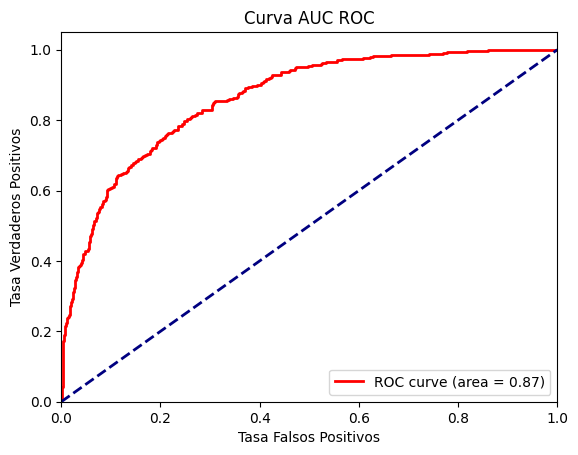

In [98]:
#Parámetros para curva roc
fpr, tpr, thresholds = roc_curve(target_valid, bosque_prob)

##Gráfico curva ACU-ROC
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {best_forest_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Curva AUC ROC')
plt.legend(loc="lower right")
plt.show()

**Prueba con GridSearch**

In [99]:
bosque2 = RandomForestClassifier()

# Definir hiperparámetros a probar
param_grid = {
    'n_estimators': [10,20,40,50,100, 200, 300], 
    'max_depth': [5,7,9,10,20,None], 
    'criterion': ['gini', 'entropy']  
}

# GridSearchCV con validación cruzada (cv=5)
grid_search = GridSearchCV(bosque2, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Ajustar el modelo
grid_search.fit(features_up, target_up)

# Mostrar la mejor combinación encontrada
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor AUC-ROC: {grid_search.best_score_:.2f}")

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 300}
Mejor AUC-ROC: 0.93


In [100]:
#Cálculo de AUC-ROC para el mejor modelo con datos de validación
mejor_bosque = grid_search.best_estimator_
bosque_grid_auc =roc_auc_score(target_valid,mejor_bosque.predict_proba(features_valid)[:,1])
print(f'AUC-ROC {bosque_grid_auc:.3f}')

AUC-ROC 0.846


Podemos ver que los parámetros escogidos por GridSearch proporcionan un modelo que logra un menor AUC-ROC, esto se debe a que el modelo se escoje de acuerdo a una validación cruzada de los datos de entrenamiento. Mientras que el proceso manual con el bucle for, se ajusta directamente con los datos de validación, motivo por el cual se obtiene un mejor score (0.87 vs 0.85).

#### 4. XGBoost

In [101]:
d_train = xgb.DMatrix(features_up,target_up)
d_valid = xgb.DMatrix(features_valid,target_valid)

#Bases de comparación 
best_xg_auc = 0.5
best_xg_acc = 0.5
best_d = 1
best_e=10
best_r =0.0001
best_xgb_acc = 0
best_xgb_f1 = 0
best_xgb_rec = 0

for d in range(1,10,1):
        for r in range(1,16,2):
             
            params = {
                'objective': 'binary:logistic',
                'max_depth': d,
                'learning_rate': r/1000,
                'eval_metric': 'logloss',
                'seed':12345
            }
            # Entrenar el modelo
            xgboost = xgb.train(params, d_train, num_boost_round=100)

            # Realizar predicciones
            xgb_prob = xgboost.predict(d_valid)
            xgb_pred = [1 if prob >= 0.5 else 0 for prob in xgb_prob]

            # Calcular métricas
            xgb_auc = roc_auc_score(target_valid, xgb_prob)
            xgb_acc = accuracy_score(target_valid,xgb_pred)
            xgb_f1 = f1_score(target_valid,xgb_pred)
            xgb_rec = recall_score(target_valid,xgb_pred)        
             
            if xgb_auc > best_xg_auc:
                 best_xg_auc = xgb_auc
                 best_d = d
                 best_r = r/1000
                 best_xgb_acc = xgb_acc
                 best_xgb_f1 = xgb_f1
                 best_xgb_rec = xgb_rec

print (f'AUC-ROC: {best_xg_auc:.3f} | Profundidad:{best_d} | Tasa de Aprendizaje: {best_r:.3f}')
print(' ')
print(f'Exactitud: {best_xgb_acc:.2f} | F1 = {best_xgb_f1:.2f} | Recall: {best_xgb_rec:.2f}')

AUC-ROC: 0.867 | Profundidad:9 | Tasa de Aprendizaje: 0.015
 
Exactitud: 0.78 | F1 = 0.65 | Recall: 0.76


In [102]:
#Hiperparámetros
params = {
   'objective': 'binary:logistic',
    'max_depth': 7,
    'learning_rate': 0.015,
    'eval_metric': 'logloss',
    'seed':12345           
    }
# Entrenar el modelo
xgboost = xgb.train(params, d_train, num_boost_round=100)

# Realizar predicciones
xgb_prob = xgboost.predict(d_valid)

In [103]:
for threshold in np.arange(0.2, 0.6, 0.02):
    xg_pred = xgb_prob > threshold
    
    thresh_acc = accuracy_score(target_valid,xg_pred)
    thresh_recall = recall_score(target_valid,xg_pred)
    thresh_f1 = f1_score(target_valid,xg_pred)
    print(f'Recall={thresh_recall:.2f} | F1: {thresh_f1:.2f} | Exactitud = {thresh_acc:.2f} | Threshold: {threshold:.2f}')

Recall=0.98 | F1: 0.53 | Exactitud = 0.54 | Threshold: 0.20
Recall=0.97 | F1: 0.54 | Exactitud = 0.57 | Threshold: 0.22
Recall=0.96 | F1: 0.55 | Exactitud = 0.59 | Threshold: 0.24
Recall=0.95 | F1: 0.56 | Exactitud = 0.60 | Threshold: 0.26
Recall=0.95 | F1: 0.57 | Exactitud = 0.62 | Threshold: 0.28
Recall=0.93 | F1: 0.57 | Exactitud = 0.64 | Threshold: 0.30
Recall=0.92 | F1: 0.58 | Exactitud = 0.65 | Threshold: 0.32
Recall=0.91 | F1: 0.59 | Exactitud = 0.67 | Threshold: 0.34
Recall=0.89 | F1: 0.60 | Exactitud = 0.69 | Threshold: 0.36
Recall=0.88 | F1: 0.60 | Exactitud = 0.70 | Threshold: 0.38
Recall=0.86 | F1: 0.62 | Exactitud = 0.72 | Threshold: 0.40
Recall=0.83 | F1: 0.62 | Exactitud = 0.73 | Threshold: 0.42
Recall=0.83 | F1: 0.63 | Exactitud = 0.74 | Threshold: 0.44
Recall=0.81 | F1: 0.63 | Exactitud = 0.75 | Threshold: 0.46
Recall=0.79 | F1: 0.64 | Exactitud = 0.77 | Threshold: 0.48
Recall=0.76 | F1: 0.64 | Exactitud = 0.77 | Threshold: 0.50
Recall=0.74 | F1: 0.64 | Exactitud = 0.7

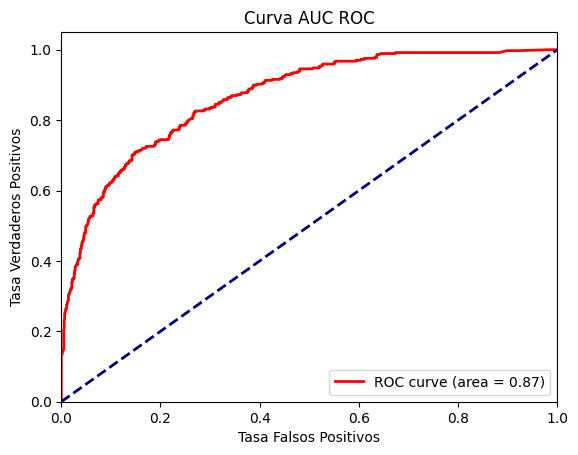

In [104]:
#Parámetros para curva roc
fpr, tpr, thresholds = roc_curve(target_valid, xgb_prob)

#Gráfica Curva AUC ROC
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {best_xg_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Curva AUC ROC')
plt.legend(loc="lower right")
plt.show()

### 5. Comparación

In [105]:
#Formación del Dataframe con Métricas
resultado_modelos = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'Árbol de Decisión', 'Bosque Aleatorio', 'XGBoost'],
    'AUC ROC': [regresion_auc, best_tree_auc, best_forest_auc, best_xg_auc],
    'Exactitud': [regresion_acc, best_tree_acc, best_forest_acc, best_xgb_acc],
    'F1':[regresion_f1,best_tree_f1,best_forest_f1,best_xgb_f1],
    'Recall':[regresion_rec,best_tree_rec,best_forest_rec,best_xgb_rec]
})

resultado_modelos = resultado_modelos.round(2)
resultado_modelos.set_index('Modelo')

,AUC ROC,Exactitud,F1,Recall
Modelo,,,,
Regresión Logística,0.84,0.76,0.62,0.77
Árbol de Decisión,0.85,0.75,0.64,0.83
Bosque Aleatorio,0.87,0.78,0.65,0.78
XGBoost,0.87,0.78,0.65,0.76


Se puede ver secuencialmente la mejora en las métricas de interés.

## MODELO ESCOGIDO

El modelo elegido es el XGboost con potenciación de Gradiente, mismo que fue el que consiguió el valor de $AUC-ROC = 0.88$ y adicional con una $Exactitud = 0.82$.

A pesar de ser el modelo mas complejo, su reducción de error produjo el resultado requerido.

### 1. XGboost

In [107]:
#Hiperparámetros
params = {
   'objective': 'binary:logistic',
    'max_depth': 7,
    'learning_rate': 0.015,
    'eval_metric': 'logloss',
    'seed':12345           
    }
# Entrenar el modelo
xgboost = xgb.train(params, d_train, num_boost_round=100)

# Realizar predicciones
xgb_prob = xgboost.predict(d_test)
xgb_pred = [1 if prob >= 0.5 else 0 for prob in xgb_prob]

# Calcular la exactitud y el AUC-ROC
xg_auc = roc_auc_score(target_test, xgb_prob)
xg_acc = accuracy_score(target_test, xgb_pred)
             
print (f'AUC ROC: {xg_auc:.3f} | Exactitud:{xg_acc:.2f}')

AUC ROC: 0.851 | Exactitud:0.77


### 2. Validación Cruzada

In [108]:
#grupos de datos con la misma proporción de clases 
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Obtención de la validación cruzada
cv_results = xgb.cv(
    params,
    d_train,
    num_boost_round=100,
    folds=cv_folds,
    metrics='auc',
    as_pandas=True,
    seed=12345
)

print(f"Promedio AUC-ROC: {cv_results['test-auc-mean'].iloc[-1]:.4f}")
print(f"Desviación estándar: {cv_results['test-auc-std'].iloc[-1]:.4f}")

Promedio AUC-ROC: 0.8969
Desviación estándar: 0.0090


El promedio de los resultados de AUC-ROC para el modelo escogido confirma que está realizando una buena predicción

In [109]:
#Matriz de confusión para el conjunto de prueba
matriz = confusion_matrix(target_test,xgb_pred)
matriz = pd.DataFrame(matriz, 
                      index=['Observación: No', 'Observación: Sí'],  
                      columns=['Predicción: No', 'Predicción: Sí']) 
matriz

,Predicción: No,Predicción: Sí
Observación: No,798,230
Observación: Sí,95,284


In [110]:
print(classification_report(target_test,xgb_pred))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1028
           1       0.55      0.75      0.64       379

    accuracy                           0.77      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.77      0.78      1407



### 3. Importancia de Características

Vamos a comprobar las Características que tienen mas influencia en el modelo seleccionado mediante dos aproximaciones:
- Características con mayor frecuencia al momento de decidir  la de división de un árbol
- Características que mas contribuyen a la mejora la predicción 

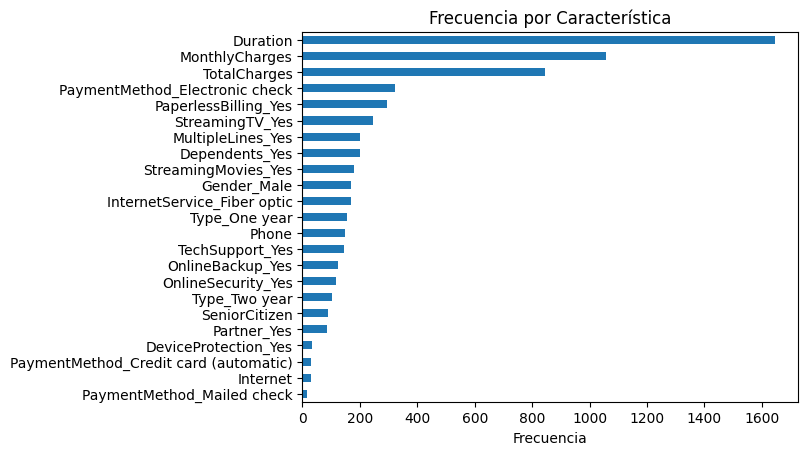

In [111]:
#Gráfico de los variables que el modelo considera mas relevantes
ver_imp= pd.DataFrame({'valor':xgboost.get_score(importance_type='weight')},index=features_train.columns)
ver_imp.sort_values(by='valor', ascending=True,inplace=True)
ver_imp.query("valor > 0",inplace=True)
ver_imp.plot(kind='barh')
plt.title('Frecuencia por Característica')
plt.xlabel('Frecuencia')
plt.legend().remove()
plt.show()

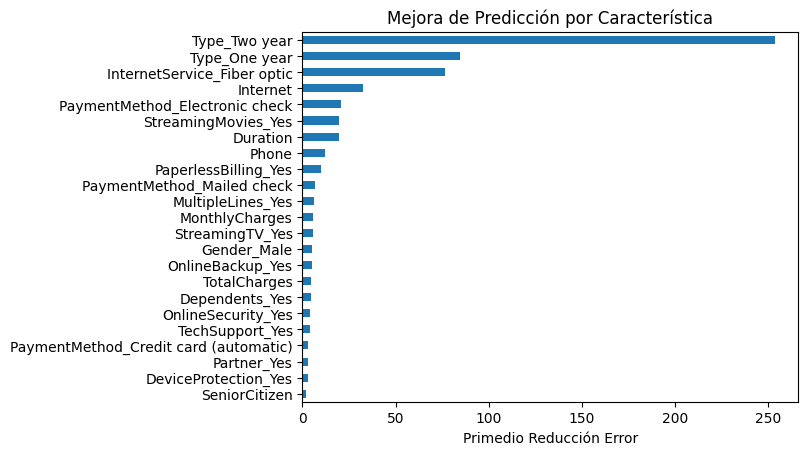

In [112]:
#Gráfico de los variables que el modelo considera mas relevantes
ver_imp= pd.DataFrame({'valor':xgboost.get_score(importance_type='gain')},index=features_train.columns)
ver_imp.sort_values(by='valor', ascending=True,inplace=True)
ver_imp.query("valor > 0",inplace=True)
ver_imp.plot(kind='barh')
plt.title('Mejora de Predicción por Característica')
plt.xlabel('Primedio Reducción Error')
plt.legend().remove()
plt.show()

- La segunda gráfica es la que mas nos ayuda a ver el impacto en la mejora del modelo, y por tanto nos indica que las características mas relevantes en la predicción son los contratos con duración amplia, lo cual es bastante lógico.
- Una característica que puede ser relevante para los otros departamentos, es 'Internet_Fiber_Optic', misma que puede ser tomada en cuenta para temas de promociones.
- La primera tabla nos indica que tanto se usaron algunas características en la generación de nuestro modelo, basados en eso, se puede considerar algo relevante al método de pago 'Electronic Chek'(correlación con Churn).
- La duración del contrato y los cargos, tanto mensuales como totales, tiene sentido que sean influyentes en el modelo.


### 1. Bosque Aleatorio con RFE

In [113]:
# Aplicar RFE para seleccionar las mejores características
rfe = RFE(estimator=bosque, n_features_to_select=4) 
rfe.fit(features_up, target_up)

print("Características seleccionadas:", list(features_up.columns[rfe.support_]))

#Eliminar características con menor importancia para train y valid
features_train_rfe = rfe.transform(features_up)
features_valid_rfe = rfe.transform(features_valid)

# Entrenar el modelo con las características seleccionadas
bosque.fit(features_train_rfe, target_up)

# Evaluar el modelo con ROC-AUC
bosque_prob = bosque.predict_proba(features_valid_rfe)[:,1]  
bosque_auc = roc_auc_score(target_valid, bosque_prob)
print(f'AUC-ROC Bosque Aleatorio después de RFE:{bosque_auc:.3f}')

Características seleccionadas: ['MonthlyCharges', 'TotalCharges', 'Duration', 'InternetService_Fiber optic']
AUC-ROC Bosque Aleatorio después de RFE:0.868


Haciendo pruebas con distintos números para el parámetros n_features_to_select, se estableció que con 4 características más importantes, se logra una mejora de 0.001 en AUC-ROC

### 2. Bosque Aleatorio con RFE en Conjunto de Prueba

In [153]:
#Reducción de características en conjunto de prueba
features_test_rfe = rfe.transform(features_test)
#Predicciones del bosque con características importantes
bosque_prob2 = bosque.predict_proba(features_test_rfe)[:,1]

#Predicción con umbral 0.5
bosque_pred = bosque_prob2>0.5

bosque_auc2 = roc_auc_score(target_test, bosque_prob2)
bosque_acc2 = accuracy_score(target_test,bosque_pred)
print(f'AUC-ROC Bosque Aleatorio Conjunto Prueba:{bosque_auc2:.3f}')
print(f'Exactitud Bosque Aleatorio Conjunto Prueba:{bosque_acc2:.2f}')

AUC-ROC Bosque Aleatorio Conjunto Prueba:0.855
Exactitud Bosque Aleatorio Conjunto Prueba:0.77


### 3. Validación Cruzada

In [115]:
#Validación cruzada con 5 particiones  
valid = np.average(cross_val_score(bosque,features_train_rfe,target_up,cv=5, scoring='roc_auc'))
print(f'Promedio AUC-ROC: {valid:.3f}')

Promedio AUC-ROC: 0.879


### 4. Matriz de Confusión

In [ ]:
#Matriz de confusión para el conjunto de prueba
matriz2 = confusion_matrix(target_test,bosque_pred)
matriz2 = pd.DataFrame(matriz2, 
                      index=['Observación: No', 'Observación: Sí'],  
                      columns=['Predicción: No', 'Predicción: Sí']) 
matriz2

,Predicción: No,Predicción: Sí
Observación: No,797,231
Observación: Sí,91,288


In [117]:
print(classification_report(target_test,bosque_pred))

              precision    recall  f1-score   support

           0       0.90      0.78      0.83      1028
           1       0.55      0.76      0.64       379

    accuracy                           0.77      1407
   macro avg       0.73      0.77      0.74      1407
weighted avg       0.81      0.77      0.78      1407



### 5. Importancia de Características

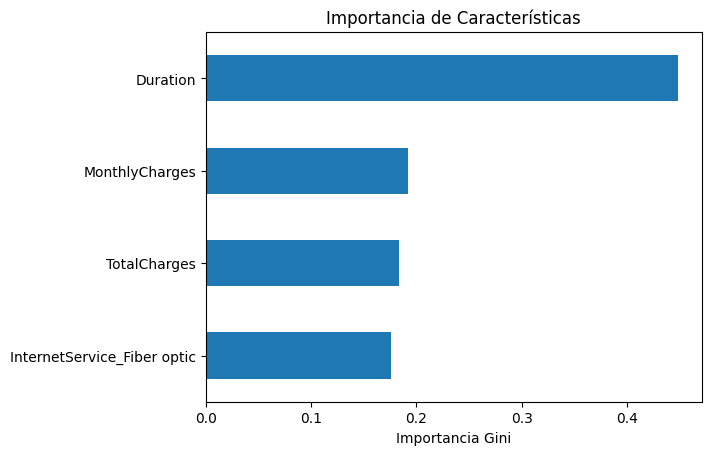

In [118]:
#Gráfico de los variables que el modelo considera mas relevantes
ver_imp= pd.DataFrame({'valor':bosque.feature_importances_},index=features_up.columns[rfe.support_])
ver_imp.sort_values(by='valor', ascending=True,inplace=True)
ver_imp.query("valor > 0",inplace=True)
ver_imp.plot(kind='barh')
plt.title('Importancia de Características')
plt.xlabel('Importancia Gini')
plt.legend().remove()
plt.show()
plt.show()

## CONCLUSIONES

- Mediante el análisis previo de los datos se determinó lo siguiente:
    - Era importante establecer una variable temporal 'Duration' que resuma la duración de cada contrato
    - Se estableció una columna objetivo 'Churn' para hacerla independiente de las fechas
    - Se eliminaron los datos de contratos que habían empezado en la misma fecha que se tomaron los datos (eran muy pocos)
    - Se intuye que las fechas de término de contrato fueron acumuladas y registradas a la vez por grupos
    - Las características en general están balanceadas entre sus categorías, y la mayoría son binarias
    - Las tablas con información personal, internet y teléfono, no contienen características altamente correlacionadas que se puedan integrar entre si.
    - Hay categorías dentro de ciertas características claramente relacionadas con la variable objetivo 'Churn' como los contratos mas cortos, la forma de pago Electronic Check, entre otros.
- Una vez realizada la consolidación de las tablas, se consideró importante crear variables adicionales que indiquen si cada cliente tiene por separado el servicio de Internet y Teléfono.
- Se realizó la eliminación columnas consideradas innecesarias (ID, BeginDate, EndDate) que no aportan información relevante, o que ya están cosideradas en Duration.
- La codificación se escogió One-Hot Encoding puesto que ya que la mayoría de columnas categóricas son binarias (Yes-No).
- Escalamiento se hizo con Min-Max scaler paque que todos los valores de la tabla se encuentren dentro del rango 0 a 1.
- Se escogió una cantidad estandar para separación de train y test (80-20) y la correción del desequilibrio de clases se hizo con sobre muestreo por la cantidad de datos.
- Se entrenaron 4 modelos escogidos en base al objetivo (clasificación) y ordenados por su complejidad, de lo que podemos concluir:
    - Las pruebas de hiperparámetros lograron mejoras marginales en cada modelo
    - La regresión Logística logró un AUC ROC de 0.77 (muy por encima de un modelo dummy) y una exactitud= que fueron la base para el resto.
    - El árbol de clasificación logró un AUC ROC=0.77 y Exactitud= 0.80, mejorando por muy poco la regresión.
    - El bosque aleatorio logró un AUC RCO=0.78 y Exactitud=0.81, con apenas 0,01 de diferencia en la métrica principal.
    - El modelo XgBoost logró un AUC ROC=0.88 y Exactitud=0.82, mejorando cosiderablemente la predicción frente a los otros modelos.
- El modelo XGboost escogido:
    - Tiene el mejor desempeño para clasificación binaria medido a través de una métrica AUC ROC = 0.88 y una exactitud=0.83
    - La validación cruzada nos ayudó a comprobar que el desempeño del modelo es estable, y no está sufriendo de sobre ajustes, logrando un promedio de 0.9 en AUC ROC
    - Las gráficas de importancia de características nos indican que hay variables que pueden ser relevantes a la hora de tomar decisiones.
    - Mas allá de las características que lógicamente están relacionadas con 'Churn', como mayores cantidades de abandono en contratos mensuales y duración del tiempo corto, variables como el tener Internet con fibra óptica y realizar sus pagos con cheques Electrónicos, mostraron tener relevancia a la hora de pronosticar si un cliente va a dejar el servcio.
- Al aplicar algunos de los cambios sugeridos, se pudo determinar que:
    - Cuando separamos en 3 grupos (entrenamiento, validación y prueba) a la vez que balanceamos con SMOTE, el XgBoost y el RandomForest lograron valores iguales en el Score AUC-ROC, mismo que llegó a un máximo de 0.87 (menor al conseguido inicialmente).
    - La herramienta GridSearch se considera bastante útil para hacer mas sencillo el proceso de escoger los hiperparámetros, a pesar de que no sea exactamente igual al ajuste manual, debido a la forma en que establecen que números son los mejores.
    - El Recursive Features Elimination si pueden mejorar la respuesta de los modelos, al priorizar las características mas importantes, a la vez que permite variar la cantidad de features para mejorar la métrica que mas nos interesa.

## INFORME DE SOLUCIÓN

Como se estableció en los Antecedentes, se han utilizado los datos personales de los clientes (planes,contratos,información adicional) de Interconnect para pronosticar su tasa de cancelación.

Para ello se estableció un analisis exploratorio de los datos con el fin de concer mas detalles de la información recolectada, que a su vez, sirvió como insumo para elaborar un Plan de Trabajo con varios puntos que permitan llegar al obejtivo final.

Del plan de trabajo inicial, se puede analizar lo siguiente:

### 1. Cumplimiento Plan de Trabajo

Se llevaron a cabo los 4 puntos generales establecidos al inicio, con los siguientes detalles:

**Preparación de Datos** 
- Se realizó la integración de información, la eliminación de información redudante, la codificación, escalamiento, separación en grupos y balanceo de clases.
- Posterior al Feedback del líder, se cambió la distribución de los datos, aumentando el de validación a los de entrenamiento y prueba iniciales.
- También se decidió probar un método diferente para generar un equilibrio de clases, cambiando un método manual de duplicación por SMOTE.
- Estos cambios mencionados tuvieron impacto posterior en el desempeño de los modelos probados.

**Modelos para Pruebas**
- Se cumplió con el establecimiento de los 4 modelos de clasificación: Regresión Logística, Arbol de Decisión, Bosque Aleatorio y XGboost.
- Aunque inicialmente solo se consideró las métricas AUC-ROC y Exactitud como las mas relevantes, se amplió la comparación a otras complementarias que pueden ser relevantes en el caso de abandono de clientes. Por ello, se adicionó el F1 y el recall al desempeño de cada modelo.
- También se hizo un análisis adicional de como se modifican las métricas de acuerdo al umbral de clasificación en cada modelo, ya que puede influir si la empresa considera aceptable tener mayor número de falsos positivo (recall).
- Aunque inicialmente se obtuvo el objetivo de AUC-ROC 0.88, al realizar las modificaciones previamente descritas, el mayor score fue de 0.87 tanto para el Bosque Aleatorio, como para XGboost con el conjunto de validación.
- Se implementó GridSearch como alternativa en el Bosque Aleatorio para comprobar su eficiencia al momento de escoger los hiperparámetros del modelo, sin embargo, se obtuvo mejores resultados haciendo un ajuste manual.
- Aunque se planteó eliminar algunas características en este momento, se decidió implementar otra herramienta en el siguiente paso, que da prioridad a las características mas importantes.

**Modelos Escogido**
- Inicialmente se escogió el modelo XGboost debido a que fue el mejor al momento de trabajar con los datos de Prueba (AUC-ROC 0.88), sin embargo, al cambiar a un grupo de validación para ajustar hiperparámetros, se observó que el desempeño fue igual al de el bosque aleatorio.
- Después de la implementación de algunos cambios, la decisión se decanta por el Random Forest por ser menos costoso computacionalmente, y porque su resultado fue igual en la métrica principal a XGboost (0.87).
- Se implementó RFE sobre el bosque aleatorio dando prioridad a las 4 mejores características, y se determinó que existe una ligera mejora en AUC-ROC (0.001), aunque no se logró llegar al 0.88 conseguido previamente. 
- Con el conjunto de prueba, el modelo RandomForest alcanzó un 0.86 de AUC-ROC, junto a una Exactitud de 0.77, Precisión=0.73, Recall=0.77 y F1=0.74.
- En el modelo final se pueden mejorar algunas de las métricas cambiando el umbral, aumentando por ejemplo el recall si se desea detectar mas posibles clientes que pueden abandonar, a costa de tener mayores falsos positivos. 

**Conclusiones**
- El EDA planteó varios desafíos, empezando porque se tuvo que generar columnas como duration y Churn para poder tener mayor facilidad al momento de pre procesar e ingresar los datos a los modelos.
- El tratamiento pre procesamiento de los datos y entrenamiento de los modelos, implica tomar en cuenta muchas variables para escoger qué métodos utilizar. En este caso en particular por el tipo de características, se determinó que era mejor escalar con Min-Max, codificar con OHE y utilizar SMOTE para balanceo.
- La decisión para el modelo final entre XGboost y RandomForest fue un poco confusa, ya que inicialmente el primer modelo consiguió un valor de 0.88 en AUC-ROC, pero posteriormente, se consideró mas conveniente RandomForest ya que es menos complejo, obtuvo iguales métricas en la validación y se pudo mejorar un poco mas con RFE.

### 3. Claves

En cada fase del proyecto se establecieron los siguientes pasos clave:

- Creación de columnas como Duratión y Churn para simplicar el tratamiento de las fechas
- Análisis de la correlación entre las características y el objetivo, así como la correlación entre las propias características
- Escoger los métodos adecuados como OHE, Min-Max Scaler, SMOTE, entre otros, para tener datos limpios y adecuados para los modelos.
- Hacer una comparación no solo del AUC-ROC, sino de métricas complementarias como exactitud, f1 y recall, para determinar el comportamiento global de cada modelo.
- Implementar las recomendaciones del líder de proyecto para comprobar diferentes comportamientos y herramientas que pueden ayudar en el objetivo de una predicción mas apegada a la realidad.
- Escoger entre dos modelos muy similares de acuerdo a la simplicidad.

### 4. Características Relevantes

Tomando en cuenta el modelo Seleccionado y el mejoramiento de características aplicado, podemos hacer una relación con el EDA para establecer información importante:

- Las características más relevantes para el Random Forest fueron:

**Columna Duration**

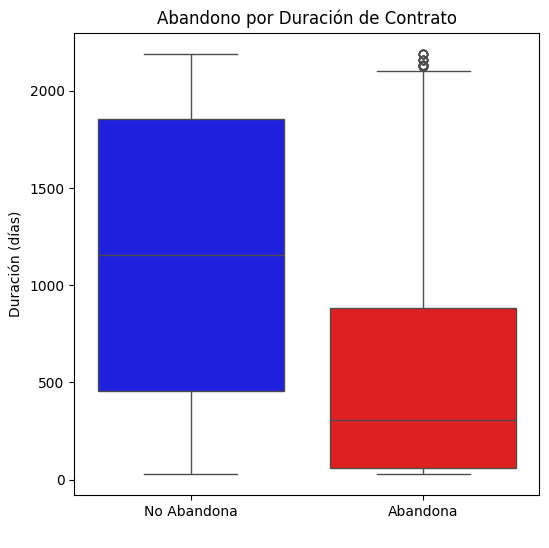

In [146]:
plt.figure(figsize=(6,6))
sns.boxplot(x=contratos['Churn'], y=contratos['Duration'],palette=['blue', 'red'])
plt.ylabel('Duración (días)')
plt.title('Abandono por Duración de Contrato')
plt.xticks([0, 1], ['No Abandona', 'Abandona'])
plt.xlabel(' ')
plt.show()

Se puede apreciar que los clientes que abandonan, tienen un promedio de aproximadamente 300 días de duración en sus contratos, por lo cuál,se puede prestar especial atención a aquellos que todavía no superan este tiempo dentro de la empresa.

También se puede establecer que aquellos clientes que han superado los 1100 días aproximadamente, son muy poco propensos a abandonar su contrato.

**Columna Monthly Charges**

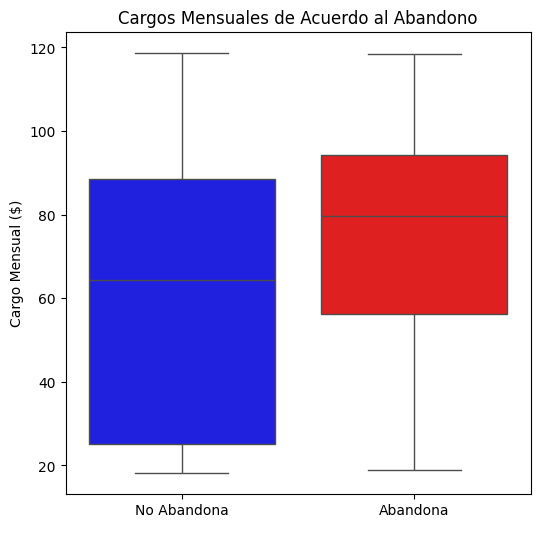

In [149]:
plt.figure(figsize=(6,6))
sns.boxplot(x=contratos['Churn'], y=contratos['MonthlyCharges'],palette=['blue','red'])
plt.title('Cargos Mensuales de Acuerdo al Abandono')
plt.ylabel('Cargo Mensual ($)')
plt.xticks([0, 1], ['No Abandona', 'Abandona'])
plt.xlabel(' ')
plt.show()

Podemos ver que aquellos usuarios con cargos mensuales medios mayores, tiende a abandonar mas el servicio.
Esto puede estar relacionado con que aquellos clientes que tienen planes mensuales, cancelen un valor mayor y no aprovechen el descuento de los planes anuales.

**Total Charges**

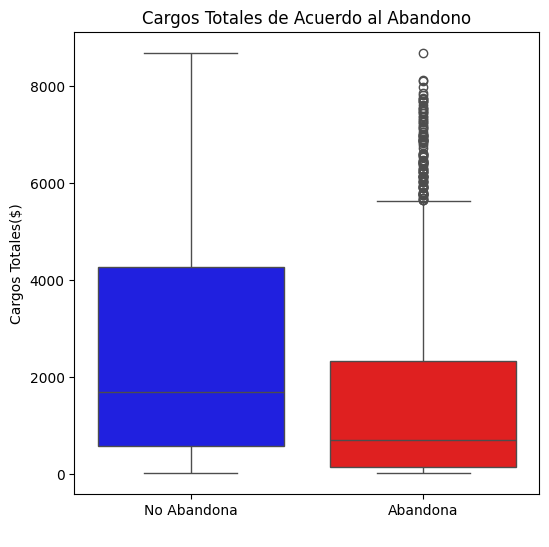

In [151]:
plt.figure(figsize=(6,6))
sns.boxplot(x=contratos['Churn'], y=contratos['TotalCharges'],palette=['blue','red'])
plt.title('Cargos Totales de Acuerdo al Abandono')
plt.ylabel('Cargos Totales($)')
plt.xticks([0, 1], ['No Abandona', 'Abandona'])
plt.xlabel(' ')
plt.show()

El gráfico muestra que aquellos que tienen un cargo total medio mayor, abandonan menos el servicio. Esto tiene sentido ya que aquellos que han permanecido mas tiempo como clientes, han acumulado mas cargos. 
Puede verse como una característica afin a la columna Duration.

**Internet Service Fiber Optic**

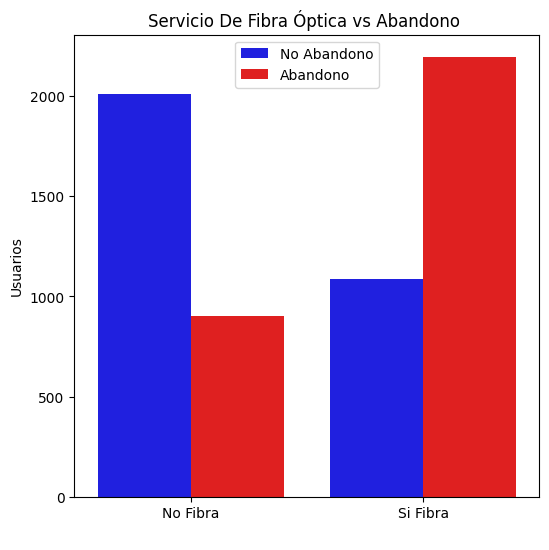

In [144]:
plt.figure(figsize=(6,6))
sns.countplot(x=features_up['InternetService_Fiber optic'], hue=target_up,palette=['blue','red'])
plt.title('Servicio De Fibra Óptica vs Abandono ')
plt.ylabel('Usuarios')
plt.xticks([0, 1], ['No Fibra', 'Si Fibra'])
plt.legend(['No Abandono','Abandono'],loc="upper center")
plt.xlabel(' ')
plt.show()

Si comparamos la relación de la característica : Tiene el servicio de internet con Fibra óptica con el abandono de servicio, podemos notar que en su mayoría, aquellos que tienen este tipo de conexión, abandonan la empresa. Y por ende, los que no usan fibra en su mayoría se mantienen como usuarios.

Tomando en cuenta este análisis, podríamos hacer recomendaciones a los departamentos de la empresa para que sus acciones se enfoquen en estas variables generales, y de manera complementaria, se puede usar el modelo de machine learning para identificar aquellos clientes puntuales mas propensos a abandonar el servicio.